# House Price Prediction

In [ ]:
#Import necessary libraries

import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from lightgbm import LGBMRegressor

import warnings
warnings.filterwarnings('ignore')

## Exploratory data Analysis

In [38]:
train = pd.read_csv("Housing_dataset_train.csv")
test = pd.read_csv("Housing_dataset_test.csv")
sub = pd.read_csv("Sample_submission.csv")
#var = pd.read_csv("VariableDefinitions.csv")

In [39]:
train.head()

,ID,loc,title,bedroom,bathroom,parking_space,price
0,3583,Katsina,Semi-detached duplex,2.0,2.0,1.0,1149999.565
1,2748,Ondo,Apartment,NaN,2.0,4.0,1672416.689
2,9261,Ekiti,NaN,7.0,5.0,NaN,3364799.814
3,2224,Anambra,Detached duplex,5.0,2.0,4.0,2410306.756
4,10300,Kogi,Terrace duplex,NaN,5.0,6.0,2600700.898


In [40]:
train[train['price'] > 0].reset_index(drop = True)

,ID,loc,title,bedroom,bathroom,parking_space,price
0,3583,Katsina,Semi-detached duplex,2.0,2.0,1.0,1149999.565
1,2748,Ondo,Apartment,NaN,2.0,4.0,1672416.689
2,9261,Ekiti,NaN,7.0,5.0,NaN,3364799.814
3,2224,Anambra,Detached duplex,5.0,2.0,4.0,2410306.756
4,10300,Kogi,Terrace duplex,NaN,5.0,6.0,2600700.898
...,...,...,...,...,...,...,...
13995,6175,Edo,Bungalow,NaN,7.0,NaN,2367927.861
13996,9704,Kaduna,Apartment,NaN,7.0,5.0,2228516.471
13997,11190,Plateau,Bungalow,8.0,6.0,5.0,2406812.693
13998,9256,Delta,Flat,NaN,6.0,1.0,3348918.718


In [41]:
train.describe()

,ID,bedroom,bathroom,parking_space,price
count,14000.000000,12201.000000,12195.000000,12189.000000,1.400000e+04
mean,4862.700357,4.308171,3.134235,3.169825,2.138082e+06
std,3818.348214,2.441165,2.035950,1.599415,1.083057e+06
min,0.000000,1.000000,1.000000,1.000000,4.319673e+05
25%,1672.750000,2.000000,1.000000,2.000000,1.393990e+06
50%,3527.000000,4.000000,2.000000,3.000000,1.895223e+06
75%,8011.250000,6.000000,5.000000,4.000000,2.586699e+06
max,12999.000000,9.000000,7.000000,6.000000,1.656849e+07


In [42]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14000 entries, 0 to 13999
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ID             14000 non-null  int64  
 1   loc            12187 non-null  object 
 2   title          12278 non-null  object 
 3   bedroom        12201 non-null  float64
 4   bathroom       12195 non-null  float64
 5   parking_space  12189 non-null  float64
 6   price          14000 non-null  float64
dtypes: float64(4), int64(1), object(2)
memory usage: 765.8+ KB


In [43]:
test.head()

,ID,loc,title,bedroom,bathroom,parking_space
0,845,Kano,Penthouse,4,1,2
1,1924,Adamawa,Apartment,2,2,4
2,10718,Adamawa,Bungalow,2,7,2
3,12076,Lagos,Mansion,9,5,2
4,12254,Gombe,Semi-detached duplex,5,6,1


In [44]:
sub.head()

,ID
0,845
1,1924
2,10718
3,12076
4,12254


In [45]:
train.title.unique()

array(['Semi-detached duplex', 'Apartment', nan, 'Detached duplex',
       'Terrace duplex', 'Mansion', 'Bungalow', 'Penthouse', 'Townhouse',
       'Flat', 'Cottage'], dtype=object)

## Creating new features, mapping and encoding existing features

In [46]:
data = train.drop("price", axis=1).append(test)

In [47]:
import pandas as pd

# Assuming your dataset is stored in a pandas DataFrame called "data"
# Replace the locations with the correct regions in this mapping dictionary
region_mapping = {
    'Abia': 'South East',
    'Adamawa': 'North East',
    'Akwa Ibom': 'South South',
    'Anambra': 'South East',
    'Bauchi': 'North East',
    'Bayelsa': 'South South',
    'Benue': 'North Central',
    'Borno': 'North East',
    'Cross River': 'South South',
    'Delta': 'South South',
    'Ebonyi': 'South East',
    'Edo': 'South South',
    'Ekiti': 'South West',
    'Enugu': 'South East',
    'Gombe': 'North East',
    'Imo': 'South East',
    'Jigawa': 'North West',
    'Kaduna': 'North West',
    'Kano': 'North West',
    'Katsina': 'North West',
    'Kebbi': 'North West',
    'Kogi': 'North Central',
    'Kwara': 'North Central',
    'Lagos': 'South West',
    'Nasarawa': 'North Central',
    'Niger': 'North Central',
    'Ogun': 'South West',
    'Ondo': 'South West',
    'Osun': 'South West',
    'Oyo': 'South West',
    'Plateau': 'North Central',
    'Rivers': 'South South',
    'Sokoto': 'North West',
    'Taraba': 'North East',
    'Yobe': 'North East',
    'Zamfara': 'North West'
}

# Create a new "region" column based on the "loc" column
data['region'] = data['loc'].map(region_mapping)

# Display the updated DataFrame
data.head()


,ID,loc,title,bedroom,bathroom,parking_space,region
0,3583,Katsina,Semi-detached duplex,2.0,2.0,1.0,North West
1,2748,Ondo,Apartment,NaN,2.0,4.0,South West
2,9261,Ekiti,NaN,7.0,5.0,NaN,South West
3,2224,Anambra,Detached duplex,5.0,2.0,4.0,South East
4,10300,Kogi,Terrace duplex,NaN,5.0,6.0,North Central


In [48]:
# Use LabelEncoder to encode regions with numerical values
label_encoder = LabelEncoder()
data['region'] = label_encoder.fit_transform(data['region'])

# Display the updated DataFrame with region_encoded column
data

,ID,loc,title,bedroom,bathroom,parking_space,region
0,3583,Katsina,Semi-detached duplex,2.0,2.0,1.0,2
1,2748,Ondo,Apartment,NaN,2.0,4.0,5
2,9261,Ekiti,NaN,7.0,5.0,NaN,5
3,2224,Anambra,Detached duplex,5.0,2.0,4.0,3
4,10300,Kogi,Terrace duplex,NaN,5.0,6.0,0
...,...,...,...,...,...,...,...
5995,1594,Ekiti,Flat,4.0,5.0,2.0,5
5996,2416,Adamawa,Terrace duplex,5.0,7.0,1.0,1
5997,10195,Oyo,Townhouse,4.0,1.0,4.0,5
5998,9455,Bauchi,Flat,3.0,7.0,5.0,1


In [49]:
# Create a new feature "bbr" (bedroom to bathroom ratio)
data['bbr'] = data['bathroom'] / data['bedroom']

# Replace infinity and -infinity values with NaN (occurs when bathroom value is 0)
data.replace([np.inf, -np.inf], np.nan, inplace=True)

# Display the updated DataFrame with the new "bbr" feature
data

,ID,loc,title,bedroom,bathroom,parking_space,region,bbr
0,3583,Katsina,Semi-detached duplex,2.0,2.0,1.0,2,1.000000
1,2748,Ondo,Apartment,NaN,2.0,4.0,5,NaN
2,9261,Ekiti,NaN,7.0,5.0,NaN,5,0.714286
3,2224,Anambra,Detached duplex,5.0,2.0,4.0,3,0.400000
4,10300,Kogi,Terrace duplex,NaN,5.0,6.0,0,NaN
...,...,...,...,...,...,...,...,...
5995,1594,Ekiti,Flat,4.0,5.0,2.0,5,1.250000
5996,2416,Adamawa,Terrace duplex,5.0,7.0,1.0,1,1.400000
5997,10195,Oyo,Townhouse,4.0,1.0,4.0,5,0.250000
5998,9455,Bauchi,Flat,3.0,7.0,5.0,1,2.333333


In [50]:
# Define the ranking based on size (arranged from smallest to biggest)
house_type_ranks = {
    'Cottage': 1,
    'Bungalow': 2,
    'Townhouse': 3,
    'Terrace duplex': 4,
    'Detached duplex': 5,
    'Semi-detached duplex': 6,
    'Flat': 7,
    'Penthouse': 8,
    'Apartment': 9,
    'Mansion': 10
}

# Map the house types to numerical values based on size ranking
data['title'] = data['title'].map(house_type_ranks)

# Print the updated dataframe
data.head()


,ID,loc,title,bedroom,bathroom,parking_space,region,bbr
0,3583,Katsina,6.0,2.0,2.0,1.0,2,1.000000
1,2748,Ondo,9.0,NaN,2.0,4.0,5,NaN
2,9261,Ekiti,NaN,7.0,5.0,NaN,5,0.714286
3,2224,Anambra,5.0,5.0,2.0,4.0,3,0.400000
4,10300,Kogi,4.0,NaN,5.0,6.0,0,NaN


In [51]:
# Calculate the frequency of each category in the 'loc' column
category_frequencies = data['loc'].value_counts(normalize=True)

# Create a dictionary to map each category to its corresponding frequency
loc_frequency_mapping = category_frequencies.to_dict()

# Map the 'loc' column to its corresponding frequency values
data['loc'] = data['loc'].map(loc_frequency_mapping)

# Print the updated dataframe
data.head()


,ID,loc,title,bedroom,bathroom,parking_space,region,bbr
0,3583,0.028592,6.0,2.0,2.0,1.0,2,1.000000
1,2748,0.028097,9.0,NaN,2.0,4.0,5,NaN
2,9261,0.027822,NaN,7.0,5.0,NaN,5,0.714286
3,2224,0.029856,5.0,5.0,2.0,4.0,3,0.400000
4,10300,0.027382,4.0,NaN,5.0,6.0,0,NaN


In [52]:
data

,ID,loc,title,bedroom,bathroom,parking_space,region,bbr
0,3583,0.028592,6.0,2.0,2.0,1.0,2,1.000000
1,2748,0.028097,9.0,NaN,2.0,4.0,5,NaN
2,9261,0.027822,NaN,7.0,5.0,NaN,5,0.714286
3,2224,0.029856,5.0,5.0,2.0,4.0,3,0.400000
4,10300,0.027382,4.0,NaN,5.0,6.0,0,NaN
...,...,...,...,...,...,...,...,...
5995,1594,0.027822,7.0,4.0,5.0,2.0,5,1.250000
5996,2416,0.028372,4.0,5.0,7.0,1.0,1,1.400000
5997,10195,0.028812,3.0,4.0,1.0,4.0,5,0.250000
5998,9455,0.028427,7.0,3.0,7.0,5.0,1,2.333333


In [53]:
train.shape[0]

14000

In [54]:
X = data[:train.shape[0]]
y = train.price
test_df = data[train.shape[0]:]

In [55]:
X.shape, y.shape, test_df.shape

((14000, 8), (14000,), (6000, 8))

### Normalizing the target values

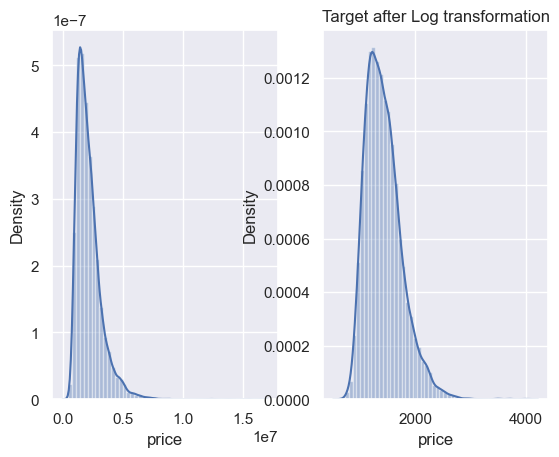

In [56]:
sns.set()
y_transformed = pd.Series(np.sqrt(y))

fig, ax = plt.subplots(1, 2)
sns.distplot(y, ax=ax[0])
plt.title("Target after Log transformation")
# ax[0].axvline(y_transformed)
sns.distplot(y_transformed, ax=ax[1])
plt.show()

### Making Naive Prediction with LightGBM Regressor

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [58]:
lgb = LGBMRegressor()
lgb.fit(X_train, y_train)
lgb_preds = lgb.predict(X_test)

print(f'mse = {mean_squared_error(y_test, lgb_preds, squared=False)}')

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000121 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 379
[LightGBM] [Info] Number of data points in the train set: 11200, number of used features: 8
[LightGBM] [Info] Start training from score 2135673.350592
mse = 586892.3788984192


In [59]:
predictions = lgb.predict(test_df)
predictions

array([2134001.29284695,  996460.66063841, 1260564.23939459, ...,
       2093734.25480552, 1453549.04783445, 3098046.85121859])

In [60]:
sub['price'] = predictions
sub.head()

,ID,price
0,845,2.134001e+06
1,1924,9.964607e+05
2,10718,1.260564e+06
3,12076,7.524640e+06
4,12254,1.898246e+06


In [61]:
sub.to_csv('baseline model.csv', index=False)

### Cross Validating the model and making predictions

In [62]:
fold_pred=[]
oof_pred = []

params = {
    'n_estimators': 500,
    'colsample_bytree': 0.86,
 'learning_rate': 0.032,
 'max_depth': 7,
    'early_stoppingearly_stopping_rounds' :100,
    'verbose' : 0,
 'subsample': 0.85}


fold = KFold(n_splits=7, shuffle=True)#15#5#10
i=1
for train_index, test_index in fold.split(X,y):     
  
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = np.log1p(y.iloc[train_index]), y.iloc[test_index]

    model = LGBMRegressor(**params, objective = "rmse")
    model.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_test, y_test)])#erly100

    preds= model.predict(X_test)
    print("err: ",(mean_squared_error(y_test,np.expm1(preds), squared=False)))  #Reverse transformation
    oof_pred.append(mean_squared_error(y_test,np.expm1(preds),squared=False))
    p2 = model.predict(test_df[X.columns])
    fold_pred.append(np.expm1(p2))
    

print(np.mean(oof_pred))

[LightGBM] [Warning] Unknown parameter: early_stoppingearly_stopping_rounds
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: early_stoppingearly_stopping_rounds
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000318 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Unknown parameter: early_stoppingearly_stopping_rounds
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: early_stoppingearly_stopping_rounds
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
err:  53258

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Unknown parameter: early_stoppingearly_stopping_rounds
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
err:  613490.7061522234
[LightGBM] [Warning] Unknown parameter: early_stoppingearly_stopping_rounds
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: early_stoppingearly_stopping_rounds
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: early_stoppingearl

### Visualizing the feature Importance

Text(0.5, 1.0, 'CatboostClassifier features importance (top 50):')

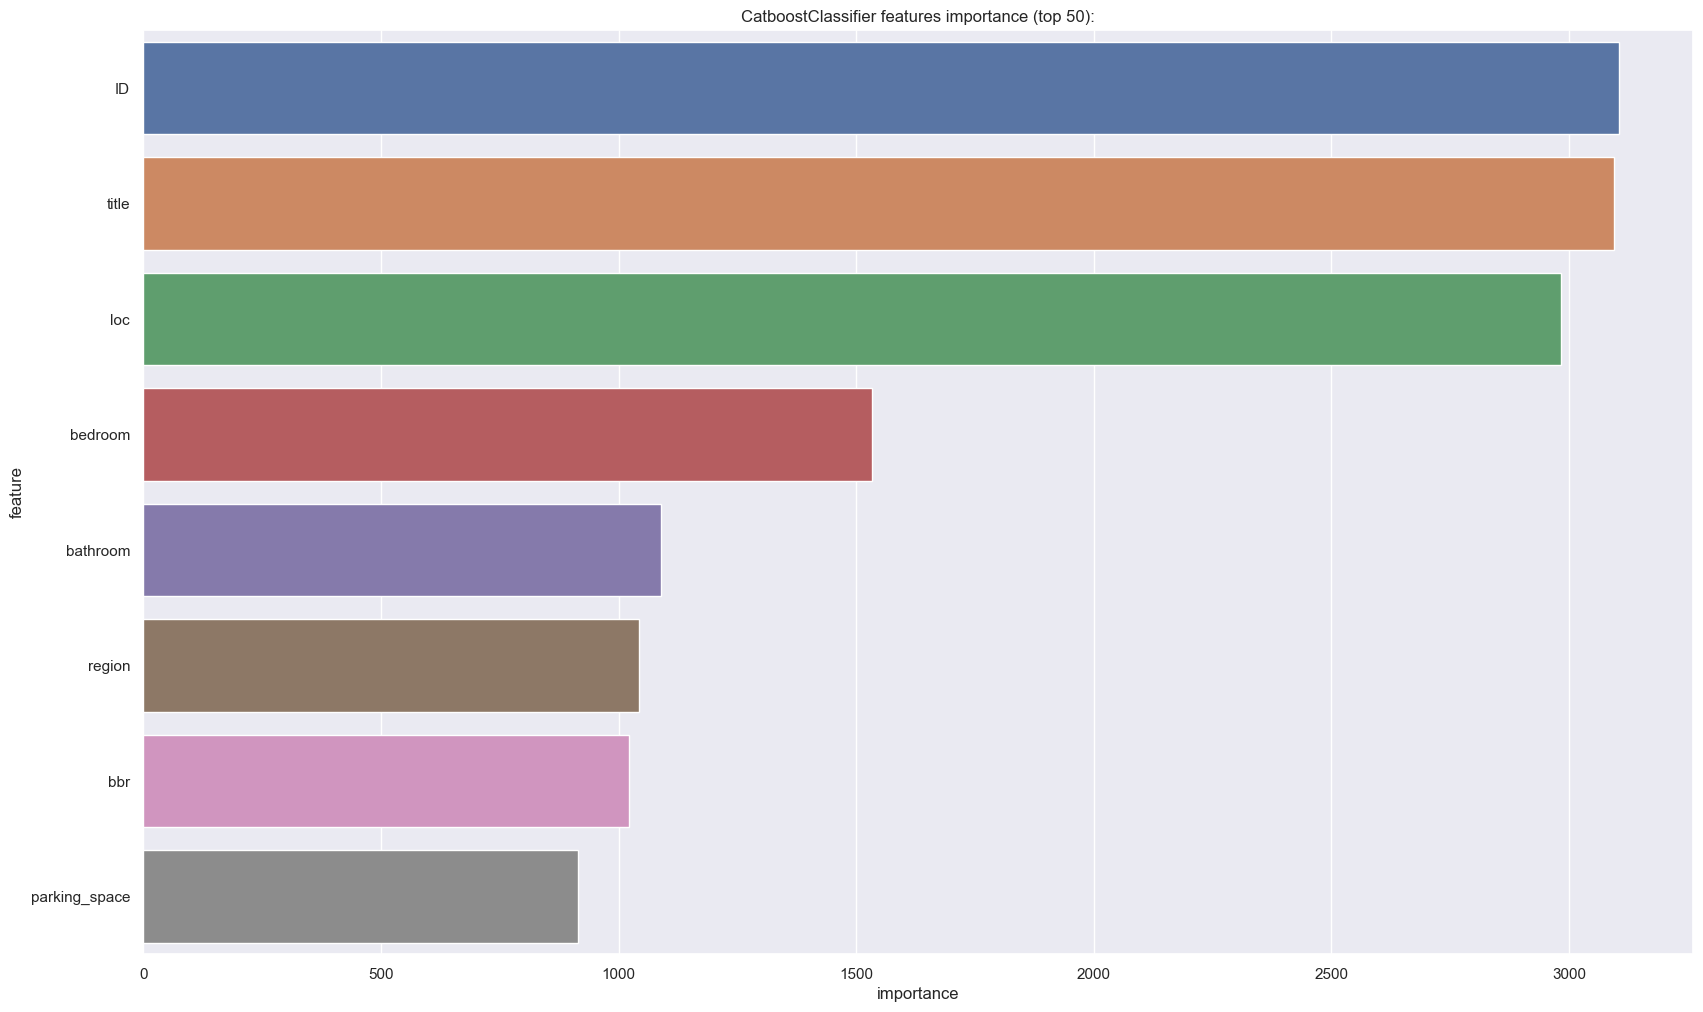

In [63]:
# # 0.7831404345536787
feature_importance_df = pd.DataFrame(model.feature_importances_, columns=['importance'])
feature_importance_df['feature'] = X.columns

plt.figure(figsize=(20, 12));
sns.barplot(x="importance", y="feature", data=feature_importance_df.sort_values(by = ['importance'], ascending = False).head(60))
plt.title('CatboostClassifier features importance (top 50):')

### Creating the submission file

In [64]:
sub.head()

,ID,price
0,845,2.134001e+06
1,1924,9.964607e+05
2,10718,1.260564e+06
3,12076,7.524640e+06
4,12254,1.898246e+06


In [ ]:
sub['price'] =  np.mean(fold_pred, axis = 0)

In [ ]:
sub.head()

In [65]:
sub.to_csv('note 14.csv', index=False)